In [1]:
import os
import pandas as pd
import numpy as np
import kipoiseq
#import pybedtools
import matplotlib.pyplot as plt
import seaborn as snsb

from architecture_linear import *
from data_utils import *
import pickle

from sklearn.metrics import average_precision_score
from interpretation_utils import *


/data/mikulik/miniconda3/envs/transformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-11 10:54:03.897167: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Genome-wide ABC predictions for 6 cell types

There are four files per cell type

* CandidateRegions.txt: the set of candidate enhancer elements for each cell type (derived from DNase-Seq or ATAC-Seq experiments) with the Activity of each element. 
* PositivePredictions.txt: Positive predictions of ABC model. Each row is an element-gene pair with ABC score >= .022. Only distal (non-promoter) elements are included.
* AllPredictions.txt: ABC Scores for all candidate element-gene pairs. Each row is an element-gene pair where the element is within 5Mb of the gene TSS. This file includes all elements (including promoter elements) and includes element-gene pairs with ABC scores < .022. It only includes ABC scores for expressed genes.
* GenePredictionStats.txt: File providing summary information for all genes considered. 
	-  The TargetGeneTSS column denotes the TSS used for the ABC model.
	- The expressed_proxy column denotes whether a gene was considered expressed (TPM or RPKM >= 1, or based on epigenetic signal at the gene promoter if expression data is not available). 
	- The geneFailedToRunThroughModel column denotes whether a gene was able to run successfully through the ABC model. Genes typically fail to run through the ABC model if there is no Hi-C data corresponding to the gene TSS in the given cell type.

Genome coordinates are in human genome build hg19 or mouse genome build mm9 (for mESC)

1. Liftover to hg38
2. predict CAGE for all genes in the set of  pairs
	- use only K562
	- use all CAGE output tracks
3. compute Input x Gradient at TSS with regard to input sequence
4. sum absolute gradient values at 3 adjacent bins (does this mean, compute one contribution score for each bin or sum the prediction of all 3 bins and backpropagate?)
5. sum contribution scores in 2kbp window centered at TSS


ABC score

$$ABCscore_{E,G} = \frac{A_E * C_{E,G}}{\sum_{e}^N A_e * C_{e, G}}$$

 Where $A_E$ defines the activity of an enhancer. The activity is defined as the geometric mean of the reads counts measured by DHS and H3K27ac ChIP-seq at element $E$. $C_{E, G}$ defines the contact frequency between an enhancer $E$ and a gene $G$ as measured by Hi-C. 

 The ABC score describes the fraction of regulation contributed by enhancer $E$ on gene $G$ out of all regulatory elements $e \in {1, ... N}$.

In [2]:
data_dir = "/data/mikulik/mnt/gcs_basenj/fulco_data/"
SEQUENCE_LENGTH = 131072

In [3]:
candidates = pd.read_csv(os.path.join(data_dir, "K562.CandidateRegions.txt"), sep="\t")
candidates["enhancer"] = candidates["chr"] + ":" + (candidates["start"]).astype("str") + "_" + (candidates["end"]).astype("str")
allpreds = pd.read_csv(os.path.join(data_dir, "K562.AllPredictions.txt"), sep="\t")
print(allpreds.shape)
allpreds.head()

(8405058, 7)


,chr,start,end,TargetGene,activity,hic_contact,ABC_Score
0,chr1,568765,569265,LOC100288069,0.0000,0.4368,0.0000
1,chr1,2191345,2191845,LOC100288069,0.6972,0.2933,0.0001
2,chr1,1243019,1244209,LOC100288069,9.8033,3.6595,0.0121
3,chr1,1542385,1542885,LOC100288069,0.3724,6.7741,0.0009
4,chr1,2300605,2301105,LOC100288069,0.2168,0.2727,0.0000


### Liftover hg37 -> hg38

First we need to do a liftover of the genomic coordinates. Importantly to be able to identify matches between regions later, I need to add a unique identifier before the liftover. 

In [4]:
rewrite = False

In [5]:
# Supplementary Table 6a. Dataset of experimentally tested noncoding element-gene connections in K562 cells
tested_pairs = pd.read_excel(os.path.join(data_dir, "Supp_Table_Fulco.xlsx"), sheet_name="Supplementary Table 6a", header=1)
tested_pairs["enhancer"] = tested_pairs.chr + ":" + tested_pairs.start.astype(str) + "_" + tested_pairs.end.astype(str)
tested_pairs.rename(columns={"Element name": "element_name", "Gene": "gene_name", "chr": "enh_chr", "start": "enh_start", "end":"enh_end", "Adjusted p-value": "adj_p_value", "Gene TSS": "gene_tss",
                                 "Normalized HiC Contacts": "normalized_hic_contact","DHS (RPM)": "dhs_rpm", "H3K27ac (RPM)": "H3K27ac_rpm", "ABC Score": "ABC_score", }, inplace=True)
tested_pairs["identifier"] = tested_pairs.gene_name + ":" + tested_pairs.enhancer
print(tested_pairs.identifier.nunique())
print(f"Number of unique genes: {tested_pairs.gene_name.nunique()}")
assert tested_pairs.identifier.nunique() == tested_pairs.shape[0]
if rewrite:
    file = open(os.path.join(data_dir, "K562_test_links_enhancer.bed"), "w")
    for i, row in tested_pairs.iterrows():
        cols = [row.enh_chr, str(row.enh_start), str(row.enh_end), row.identifier, row.gene_name]
        print("\t".join(cols), file=file)
    file.close()

if rewrite:
    file = open(os.path.join(data_dir, "K562_test_links_genes.bed"), "w")
    for i, row in tested_pairs.iterrows():
        cols = [row.enh_chr, str(row.gene_tss), str(row.gene_tss), row.identifier, row.gene_name]
        print("\t".join(cols), file=file)
    file.close()

5091
Number of unique genes: 65


/data/mikulik/miniconda3/envs/transformer/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/data/mikulik/miniconda3/envs/transformer/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


## LiftOver to hg38 
Load the `gene_summary` and `PositivePredictions` and `fulco_links` tables after liftover.

In [6]:
test_genes = pd.read_csv(os.path.join(data_dir, "K562_test_links_genes_hg38.bed"), sep="\t", header=None)
test_genes.columns = ["gene_chr", "gene_start", "gene_end", "identifier", "gene_name"]
test_genes = test_genes[["gene_chr", "gene_start", "gene_end", "identifier"]]
test_enhancers = pd.read_csv(os.path.join(data_dir, "K562_test_links_enhancer_hg38.bed"), sep="\t", header=None)
test_enhancers.columns = ["enh_chr", "enh_start", "enh_end", "identifier", "gene_name"]
test_enhancers = test_enhancers[["enh_chr", "enh_start", "enh_end", "identifier"]]


In [7]:
tested_pairs = tested_pairs[["identifier", "gene_name", "class", "normalized_hic_contact", "dhs_rpm", "H3K27ac_rpm", "ABC_score", "Significant"]]
assert tested_pairs.identifier.nunique() == test_enhancers.identifier.nunique() == test_genes.identifier.nunique()
tested_pairs = tested_pairs.merge(test_enhancers, on="identifier", how="left")
tested_pairs = tested_pairs.merge(test_genes, on="identifier", how="left")
tested_pairs

,identifier,gene_name,class,normalized_hic_contact,dhs_rpm,H3K27ac_rpm,ABC_score,Significant,enh_chr,enh_start,enh_end,gene_chr,gene_start,gene_end
0,MYC:chr8:128189625_128192185,MYC,intergenic,8.480640,0.692727,0.102361,0.000177,False,chr8,127177380,127179940,chr8,127736068,127736068
1,MYC:chr8:128208622_128211122,MYC,promoter,0.436815,0.073571,0.000000,0.000000,False,chr8,127196377,127198877,chr8,127736068,127736068
2,MYC:chr8:128230263_128232763,MYC,promoter,2.887005,0.091094,0.000000,0.000000,False,chr8,127218018,127220518,chr8,127736068,127736068
3,MYC:chr8:128578205_128580765,MYC,intergenic,5.957806,1.259657,3.685002,0.001005,False,chr8,127565960,127568520,chr8,127736068,127736068
4,MYC:chr8:128627285_128629785,MYC,intergenic,3.962938,0.463822,0.307083,0.000117,False,chr8,127615040,127617540,chr8,127736068,127736068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5086,WDR83OS:chr19:13507325_13507905,WDR83OS,genic,0.436815,1.614458,1.125973,0.000087,False,chr19,13396511,13397091,chr19,12669651,12669651
5087,WDR83OS:chr19:13512165_13512685,WDR83OS,genic,0.436815,2.684034,2.559029,0.000169,False,chr19,13401351,13401871,chr19,12669651,12669651
5088,WDR83OS:chr19:13539145_13539665,WDR83OS,genic,0.436815,0.733656,0.204722,0.000025,False,chr19,13428331,13428851,chr19,12669651,12669651
5089,WDR83OS:chr19:13648285_13648785,WDR83OS,intergenic,0.436815,1.536401,0.614167,0.000062,False,chr19,13537471,13537971,chr19,12669651,12669651


After computing contribution scores we will sum all gradient x input scores in a 2kbp window centered at the enhancer. Below I compute the enhancer center coordinate, as well as the distance of the enhancer center form the gene TSS. 

Then I exclude any enhancer-gene pairs that are more than 131,072/2 bp apart. 



Unique genes: 65
There are 5091 positive predicted links in total


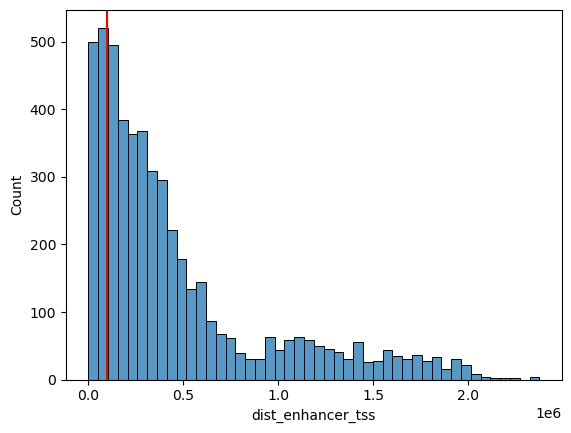

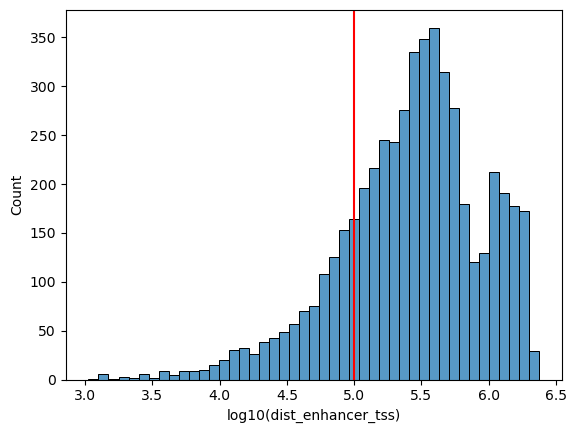

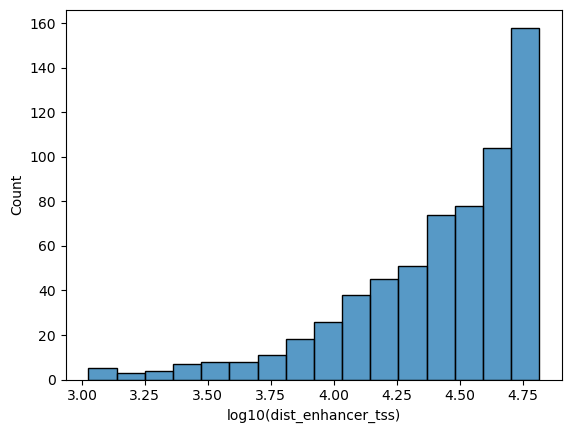

There are 638 positive predicted links within 131kbp / 2 of TSS


In [8]:
print(f"Unique genes: {tested_pairs.gene_name.nunique()}")
tested_pairs["enhancer"] = tested_pairs["enh_chr"] + ":" + (tested_pairs["enh_start"]).astype("str") + "_" + (tested_pairs["enh_end"]).astype("str")
tested_pairs["enhancer_center"] = (tested_pairs.enh_start + tested_pairs.enh_end) // 2
tested_pairs["dist_enhancer_tss"] = np.abs(tested_pairs.enhancer_center - tested_pairs.gene_start)
print(f"There are {tested_pairs.shape[0]} positive predicted links in total")


sns.histplot(tested_pairs.dist_enhancer_tss)
plt.axvline(1e5, color="red")
plt.show()
sns.histplot(np.log10(tested_pairs.dist_enhancer_tss))
plt.axvline(np.log10(1e5), color="red")
plt.xlabel("log10(dist_enhancer_tss)")
plt.show()


tested_pairs = tested_pairs[tested_pairs.dist_enhancer_tss < SEQUENCE_LENGTH//2]
sns.histplot(np.log10(tested_pairs.dist_enhancer_tss))
plt.xlabel("log10(dist_enhancer_tss)")
plt.show()
print(f"There are {tested_pairs.shape[0]} positive predicted links within 131kbp / 2 of TSS")

In [9]:
print(f"{tested_pairs.Significant.sum()} out of these are signficant links where the enhancer had an impact on gene expression.")

123 out of these are signficant links where the enhancer had an impact on gene expression.


Trying Captum, but not sure how this works....

In [10]:
#import captum
#input_x_gradient = captum.attr.InputXGradient(model)

#mask = np.expand_dims(target_mask, axis=0)
#print(mask.shape)
#mask = torch.from_numpy(mask)

#attribution = input_x_gradient.attribute(torch.tensor(input).unsqueeze(0), target=(0,1), 
                                            #additional_forward_args=(None, False, False, False, False, "human"),
                                            #target = None, return_corr_coef = False,return_embeddings = False,return_only_embeddings = False,return_loss_per_bp = False,head = "human"))

# Contributions

In [11]:


# specify where the model is saved
#model_path = "/data/mikulik/mnt/gcs_basenj/models/"
#model_name = "enf_train_v2_batch_2_lr_1e3_linear_noit_0.0001_2_augmentTrue_validation_state_dict.pt"
#data_dir = "/data/mikulik/mnt/gcs_basenj/"
#
## initialize the model and contribution class
##contr = KatformerContribution(model_path, model_name)
#
## initialize fasta extractor
#human_fasta_path = os.path.join(data_dir, "hg38.ml.fa")
#fasta_extractor = FastaStringExtractor(human_fasta_path)
#
## get the experiment indices for K562 CAGE
#target_df = pd.read_csv(os.path.join(data_dir, "human", "targets.txt"), sep="\t", index_col=0)
#k562_index = target_df[(target_df.description.str.contains("CAGE")) & target_df.description.str.contains("K562")].index
#
## initialize target mask
#target_mask = np.zeros((896, 5313))
#for seq_idx in [447, 448, 449]:
#  for exp_idx in k562_index: # get only the CAGE tracks for K562
#    target_mask[seq_idx, exp_idx] = 1
#print(target_mask.shape)
#counts = 0

In [12]:
# expand the gene window around the tss to 131/2 kbp
tested_pairs["tss_coord"] = tested_pairs.gene_start
for i, row in tested_pairs.iterrows():
    interval = kipoiseq.Interval(row.enh_chr, row.tss_coord, row.tss_coord).resize(SEQUENCE_LENGTH)
    tested_pairs.loc[i, "gene_start"] = interval.start
    tested_pairs.loc[i, "gene_end"] = interval.end
tested_pairs["gene_length"] = tested_pairs.gene_end - tested_pairs.gene_start
assert (tested_pairs.gene_length == SEQUENCE_LENGTH).all()
assert (np.abs(tested_pairs.gene_start - tested_pairs.tss_coord) == SEQUENCE_LENGTH//2).all()

/tmp/ipykernel_24730/2815276544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tested_pairs["tss_coord"] = tested_pairs.gene_start
/tmp/ipykernel_24730/2815276544.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tested_pairs["gene_length"] = tested_pairs.gene_end - tested_pairs.gene_start


(616, 21)

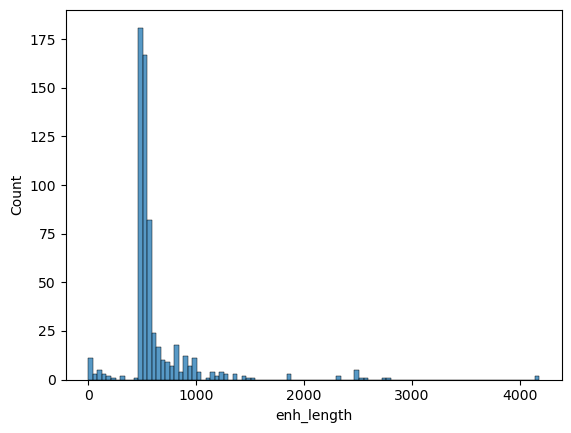

In [13]:
# make sure that the 2 kbp enhancer window is fully enclosed by the 131 kbp window around the TSS
tested_pairs = tested_pairs[(tested_pairs.enhancer_center - tested_pairs.gene_start >= 1000) & (tested_pairs.gene_end -tested_pairs.enhancer_center >= 1000)]
tested_pairs["enh_length"] = np.abs(tested_pairs.enh_end - tested_pairs.enh_start)
sns.histplot(tested_pairs.enh_length, bins=100)
# remove enahncers with length 0
tested_pairs = tested_pairs[tested_pairs["enh_length"] != 0]
tested_pairs["1/distance"] = 1/tested_pairs.dist_enhancer_tss
tested_pairs.rename(columns={"dist_enhancer_tss": "distance_enhancer_tss"}, inplace=True)
tested_pairs.shape

In [14]:
#tested_pairs.rename(columns={"dist_enhancer_tss": "distance_enhancer_tss"}, inplace=True)
#conditions = [
#    (tested_pairs.distance_enhancer_tss <= 3e3),
#    (tested_pairs.distance_enhancer_tss > 3e3) & (tested_pairs.distance_enhancer_tss <= 12.5e3),
#    (tested_pairs.distance_enhancer_tss > 12.5e3) & (tested_pairs.distance_enhancer_tss <= 34.5e3),
#    (tested_pairs.distance_enhancer_tss > 34.5e3) & (tested_pairs.distance_enhancer_tss <= SEQUENCE_LENGTH/2),
#]
#
#values = ["0-3 kbp", "3-12.5 kbp", "12.5-34.5 kbp", "34.5 kbp -65.5 kbp"]
#tested_pairs["distance_bin"] = np.select(conditions, values)
#auprc_df = tested_pairs.copy()
#
#auprc_df.sort_values(by="distance_bin",ascending=True, inplace=True)
#sns.histplot(data=auprc_df, x="distance_bin", hue="Significant", multiple="dodge")


In [15]:
#auprc_dict = {}
#pos, neg, ratios = [], [], []
#for distance_bin in auprc_df.distance_bin.unique():
#    #print(distance_bin)
#    #print(auprc_df.loc[auprc_df.distance_bin == distance_bin].shape)#, "distance_bin_mean"] = auprc_df[auprc_df.distance_bin == distance_bin].link_score.mean()
#    sub = auprc_df.loc[auprc_df.distance_bin == distance_bin]
#    y_true = sub.Significant.values
#    y_scores = sub.ABC_score.values
#    y_agnostic = sub.H3K27ac_rpm.values
#    y_distance = sub["distance_enhancer_tss"].values
#    y_dhs = sub.dhs_rpm.values
#    y_hic = sub.normalized_hic_contact.values
#    ratios.append(np.abs(sub["Significant"].sum()) / sub.shape[0])
#    pos.append(int(np.abs(sub["Significant"].sum())))
#    neg.append(int(np.abs(sub.shape[0] - int(np.abs(sub["Significant"].sum())) )))
#    #ratio = np.round(num_positives / num_negatives, decimals=2)
#    cell_type_auprc = np.round(average_precision_score(y_true, y_scores), decimals=2)
#    distance_auprc = np.round(average_precision_score(y_true, y_distance), decimals=2)
#    agnostic_auprc = np.round(average_precision_score(y_true, y_agnostic), decimals=2)
#    dhs_auprc = np.round(average_precision_score(y_true, y_dhs), decimals=2)
#    hic = np.round(average_precision_score(y_true, y_hic), decimals=2)
#    auprc_dict[f"{distance_bin}"] = [cell_type_auprc, agnostic_auprc, dhs_auprc, hic, distance_auprc]
#    
#    print(f"Bin {distance_bin}: ABC-score: {cell_type_auprc}, H3K27ac: {agnostic_auprc}, DHS: {dhs_auprc}, normalized_hic_contact:{hic}, distance: {distance_auprc}")
#

In [16]:
#auprc_dict_df = pd.DataFrame(auprc_dict, index=["ABC", "H3K27ac", "DHS", "HIC", "distance"])#, "num_positives", "num_negatives", "ratio"])
## convert this dataframe to long format
#auprc_dict_df = auprc_dict_df.stack().reset_index().rename(columns={"level_0":"type", "level_1":"distance_bin", 0:"auprc"})
##print(auprc_dict_df)
#auprc_dict_df.sort_values(by="distance_bin", ascending=True, inplace=True)
## make a bar plot of auprc_dict_df with seaborn and add the number of instances in each bin
#sns.barplot(data=auprc_dict_df, x="distance_bin", y="auprc", hue="type")
#for i, name, color in zip(ratios, ["bin1", "bin2", "bin3", "bin4"], ["red", "blue", "green", "orange"]):
#    plt.axhline(y=i, color=color, linestyle="--", label=name)
#plt.legend()
#print(pos)
#print(neg)
##create a list with the fraction of the above two list entries
#ratio = [np.round(pos[i] / neg[i], decimals=2) for i in range(len(pos))]
#print(ratio)
#

# Small model

In [17]:


# specify where the model is saved
model_path = "/data/mikulik/mnt/gcs_basenj/train_enformer_month/"
model_name = "enf_train_v2_batch_2_lr_1e3_linear_noit_0.0001_2_augmentTrue_validation_state_dict.pt"
data_dir = "/data/mikulik/mnt/gcs_basenj/"

# initialize fasta extractor
human_fasta_path = os.path.join(data_dir, "hg38.ml.fa")
fasta_extractor = FastaStringExtractor(human_fasta_path)

# get the experiment indices for K562 CAGE
target_df = pd.read_csv(os.path.join(data_dir, "human", "targets.txt"), sep="\t", index_col=0)
k562_index = target_df[(target_df.description.str.contains("CAGE")) & target_df.description.str.contains("K562")].index

# initialize target mask
target_mask = np.zeros((896, 5313))
for seq_idx in [447, 448, 449]:
  for exp_idx in k562_index: # get only the CAGE tracks for K562
    target_mask[seq_idx, exp_idx] = 1
print(target_mask.shape)
print(target_mask.sum())
counts = 0

(896, 5313)
6.0


In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")
print(f"Number of GPUs available: {torch.cuda.device_count()}")


Using: cpu
Number of GPUs available: 0


Careful depending on whether I import a model architecture that contains a linear layer in the attention block or not!

In [19]:
tested_pairs

,identifier,gene_name,class,normalized_hic_contact,dhs_rpm,H3K27ac_rpm,ABC_score,Significant,enh_chr,enh_start,...,gene_chr,gene_start,gene_end,enhancer,enhancer_center,distance_enhancer_tss,tss_coord,gene_length,enh_length,1/distance
7,MYC:chr8:128736885_128739385,MYC,genic,52.310740,1.376260,1.023612,0.004860,False,chr8,127724639,...,chr8,127670532,127801604,chr8:127724639_127727139,127725889,10179,127736068,131072,2500,0.000098
8,MYC:chr8:128739945_128742485,MYC,genic,100.000000,2.288137,0.102361,0.003788,False,chr8,127727699,...,chr8,127670532,127801604,chr8:127727699_127730239,127728969,7099,127736068,131072,2540,0.000141
9,MYC:chr8:128757345_128759905,MYC,intergenic,49.134016,0.877985,0.307083,0.001997,False,chr8,127745099,...,chr8,127670532,127801604,chr8:127745099_127747659,127746379,10311,127736068,131072,2560,0.000097
10,MYC:chr8:128770725_128773225,MYC,intergenic,23.014598,8.489623,2.251945,0.007860,False,chr8,127758479,...,chr8,127670532,127801604,chr8:127758479_127760979,127759729,23661,127736068,131072,2500,0.000042
11,MYC:chr8:128771725_128774485,MYC,intergenic,23.014598,8.489623,2.251945,0.007860,False,chr8,127759479,...,chr8,127670532,127801604,chr8:127759479_127762239,127760859,24791,127736068,131072,2760,0.000040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4998,WDR83OS:chr19:12813805_12814305,WDR83OS,promoter,11.663912,2.222350,0.614167,0.002007,False,chr19,12702991,...,chr19,12604115,12735187,chr19:12702991_12703491,12703241,33590,12669651,131072,500,0.000030
4999,WDR83OS:chr19:12827685_12828205,WDR83OS,genic,4.589816,4.808330,0.614167,0.001162,False,chr19,12716871,...,chr19,12604115,12735187,chr19:12716871_12717391,12717131,47480,12669651,131072,520,0.000021
5000,WDR83OS:chr19:12832705_12833225,WDR83OS,promoter,6.483757,2.112461,6.653476,0.003573,False,chr19,12721891,...,chr19,12604115,12735187,chr19:12721891_12722411,12722151,52500,12669651,131072,520,0.000019
5001,WDR83OS:chr19:12833305_12833805,WDR83OS,promoter,6.483757,12.562593,4.401530,0.007127,False,chr19,12722491,...,chr19,12604115,12735187,chr19:12722491_12722991,12722741,53090,12669651,131072,500,0.000019


In [20]:

def get_contribution_scores_enhancer_gene(contr_model, pairs_df, target_mask):
   contr_dict = {"gene_stable_id": [], "interval": [], "contr": [], "prediction": [], "enhancers": []}
   print(pairs_df.gene_name.unique())
   for gene in pairs_df.gene_name.unique():
      #print(gene)
      # get enhancer regions 
      enhancer_df = pairs_df[pairs_df.gene_name == gene]
      row = enhancer_df.iloc[0]
      if len(enhancer_df) != 0:
         contr_dict["gene_stable_id"].append(gene)

         # get 131 kbp sequence centered around TSS
         interval = kipoiseq.Interval(row.gene_chr, row.gene_start, row.gene_end)#.resize(SEQUENCE_LENGTH) 
         assert len(interval) == 131072
         contr_dict["interval"].append(interval)

         # one hot encode sequence
         sequence_one_hot = torch.from_numpy(np.expand_dims(one_hot_encode(fasta_extractor.extract(interval)), axis=0))

         inp_grad, prediction = contr_model.input_x_gradient(sequence_one_hot, torch.from_numpy(target_mask), head = "human",plot=False)
         contr_dict["prediction"].append(prediction)
         contr_dict["contr"].append(inp_grad.numpy())


         # add enhancer id and mask for 2 kbp window around enhancer center for gene i
         enh_dict = {}
         for j, row_enh in enhancer_df.iterrows():
            enhancer_mask = np.zeros(len(interval))
            enhancer_interval = kipoiseq.Interval(row_enh.enh_chr, row_enh.enhancer_center, row_enh.enhancer_center).resize(2000)
            idx1, idx2 = np.abs(interval.start - enhancer_interval.start), np.abs(interval.start - enhancer_interval.end)
            enhancer_mask[idx1:idx2] = 1
            assert enhancer_mask.sum() == 2000
            enh_dict[row_enh.enhancer] = enhancer_mask
         contr_dict["enhancers"].append(enh_dict)
   return contr_dict

In [25]:
save = False
if save:
    contr_comp = ComputeContribution(model_path, model_name, data_parallel=False)
    eg_links_small = get_contribution_scores_enhancer_gene(contr_comp, tested_pairs, target_mask)
else:
    with open(os.path.join(data_dir, "train_enformer_month", "eg_links_best_small_enformer.pkl"), "rb") as f:
        eg_links_small = pickle.load(f)# get_contribution_scores_enhancer_gene(contr_comp, tested_pairs, target_mask)


In [ ]:
#counts = 0
#contr_dict = {"gene_stable_id": [], "interval": [], "contr": [], "prediction": [], "enhancers": []}
#contr_comp = ComputeContribution(model_path, model_name, data_parallel=False)
#print(target_mask.sum())
#
#
#
#contr_dict = {"gene_stable_id": [], "interval": [], "contr": [], "prediction": [], "enhancers": []}
#
#for gene in tested_pairs.gene_name.unique():
#    # get enhancer regions 
#    enhancer_df = tested_pairs[tested_pairs.gene_name == gene]
#    row = enhancer_df.iloc[0]
#    if len(enhancer_df) != 0:
#      contr_dict["gene_stable_id"].append(gene)
#
#      # get 131 kbp sequence centered around TSS
#      interval = kipoiseq.Interval(row.gene_chr, row.gene_start, row.gene_end)#.resize(SEQUENCE_LENGTH) 
#      assert len(interval) == 131072
#      contr_dict["interval"].append(interval)
#
#      # one hot encode sequence
#      sequence_one_hot = torch.from_numpy(one_hot_encode(fasta_extractor.extract(interval)))
#
#      inp_grad, prediction = contr_comp.input_x_gradient(sequence_one_hot, torch.from_numpy(target_mask), head = "human",plot=False)
#      print(inp_grad.shape, prediction.shape)
#      contr_dict["prediction"].append(prediction)
#      contr_dict["contr"].append(inp_grad.numpy())
#
#
#      # add enhancer id and mask for 2 kbp window around enhancer center for gene i
#      enh_dict = {}
#      for j, row_enh in enhancer_df.iterrows():
#         enhancer_mask = np.zeros(len(interval))
#         enhancer_interval = kipoiseq.Interval(row_enh.enh_chr, row_enh.enhancer_center, row_enh.enhancer_center).resize(2000)
#         idx1, idx2 = np.abs(interval.start - enhancer_interval.start), np.abs(interval.start - enhancer_interval.end)
#         enhancer_mask[idx1:idx2] = 1
#         assert enhancer_mask.sum() == 2000
#         enh_dict[row_enh.enhancer] = enhancer_mask
#      contr_dict["enhancers"].append(enh_dict)#
#
#      counts += 1
#      #if counts > 4:
#       #  break
#print(counts)      

In [26]:
def plot_tracks(tracks, interval, height=1.5):
    fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
    for ax, (title, y) in zip(axes, tracks.items()):
        ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
        ax.set_title(title)
        sns.despine(top=True, right=True, bottom=True)
    ax.set_xlabel(str(interval))
    plt.tight_layout()

def get_enhancer_gene_scores(contr_dict, plot = False):
    #plot = True
    link_dict = {"gene_id": [], "enhancer_id": [], "link_score": []}
    for i in range(len(contr_dict["contr"])):
        grads = contr_dict["contr"][i]
        gene_name = contr_dict["gene_stable_id"][i]
        for enhancer_id, enh_mask in contr_dict["enhancers"][i].items():
            link_score = np.abs(grads * enh_mask).sum()
            link_dict["gene_id"].append(gene_name)
            link_dict["enhancer_id"].append(enhancer_id)
            link_dict["link_score"].append(link_score)#.numpy())
    return pd.DataFrame(link_dict)


### Add distance bins to the E-G link dataframe

In [27]:
def add_distance_bins(enhancer_gene_link_df, tested_pairs, plot=False):
    enhancer_gene_link_df.rename(columns={"gene_id": "gene_name", "enhancer_id": "enhancer", "link_score": "enformer_score"}, inplace=True)
    auprc_df = enhancer_gene_link_df.merge(tested_pairs, on = ["gene_name", "enhancer"], how="left")
    auprc_df.rename(columns={"dist_enhancer_tss": "distance_enhancer_tss"}, inplace=True)
    conditions = [
        (auprc_df.distance_enhancer_tss <= 3e3),
        (auprc_df.distance_enhancer_tss > 3e3) & (auprc_df.distance_enhancer_tss <= 12.5e3),
        (auprc_df.distance_enhancer_tss > 12.5e3) & (auprc_df.distance_enhancer_tss <= 34.5e3),
        (auprc_df.distance_enhancer_tss > 34.5e3)
    ]

    values = ["0-3 kbp", "3-12.5 kbp", "12.5-34.5 kbp", "34.5 kbp -100 kbp"]
    auprc_df["distance_bin"] = np.select(conditions, values)

    auprc_df.sort_values(by="distance_bin",ascending=True, inplace=True)
    
    if plot:
        sns.histplot(data=auprc_df, x="distance_bin", hue="Significant", multiple="dodge")
        plt.show()
    return auprc_df


In [28]:
def compute_average_precision_per_bin(auprc_df, plot=False):
    auprc_dict = {}
    ratios = {"pos":[], "neg":[], "ratios": []}
    for distance_bin in auprc_df.distance_bin.unique():
        sub = auprc_df.loc[auprc_df.distance_bin == distance_bin]
        y_true = sub.Significant.values
        enformer = np.round(average_precision_score(y_true, sub.enformer_score.values), 2)
        abc = np.round(average_precision_score(y_true, sub.ABC_score.values), 2)
        h3k27 = np.round(average_precision_score(y_true, sub.H3K27ac_rpm.values), 2)
        distance = np.round(average_precision_score(y_true, sub.distance_enhancer_tss.values), 2)
        hic = np.round(average_precision_score(y_true, sub.normalized_hic_contact.values), 2)
        auprc_dict[f"{distance_bin}"] = [enformer, abc, h3k27, distance, hic]

        ratios["ratios"].append(np.abs(sub.Significant.sum()) / sub.shape[0])
        ratios["pos"].append(int(np.abs(sub.Significant.sum())))
        ratios["neg"].append(int(np.abs(sub.shape[0] - int(np.abs(sub.Significant.sum())) )))

    auprc_dict_df = pd.DataFrame(auprc_dict, index = ["enformer", "abc", "h3k27", "distance", "hic"])
    auprc_dict_df = auprc_dict_df.stack().reset_index().rename(columns={"level_0":"type", "level_1":"distance_bin", 0:"auprc"})
    auprc_dict_df.sort_values(by="distance_bin", ascending=True, inplace=True)

    if plot:
        sns.barplot(data=auprc_dict_df, x="distance_bin", y="auprc", hue="type")
        for i, name, color in zip(ratios["ratios"], ["bin1", "bin2", "bin3", "bin4"], ["red", "blue", "green", "orange"]):
            plt.axhline(y=i, color=color, linestyle="--", label=name)
        plt.legend()
        plt.show()

    return auprc_dict_df, ratios


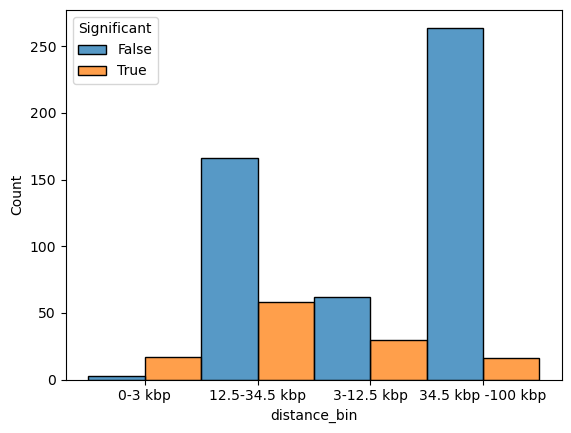

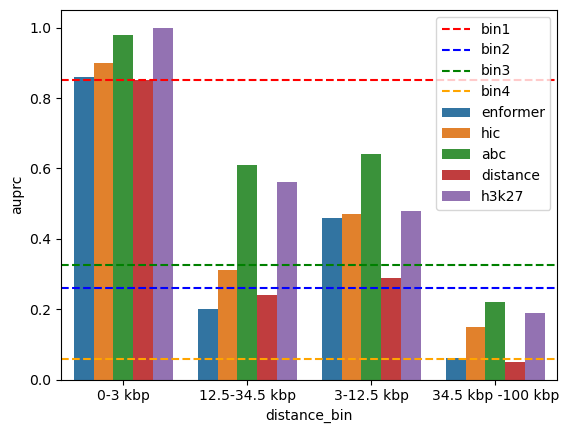

,0,1,2,3
pos,17.00,58.000000,30.000000,16.000000
neg,3.00,166.000000,62.000000,264.000000
ratios,0.85,0.258929,0.326087,0.057143


In [29]:
links = get_enhancer_gene_scores(eg_links_small, plot = False)
auprc_df = add_distance_bins(links, tested_pairs, plot=True)
df, ratio_df = compute_average_precision_per_bin(auprc_df, plot=True)
pd.DataFrame(ratio_df).T

# Basenji contribution scores

In [30]:
import sys
sys.path.append("/data/mikulik/mnt/katformer/")
from Basenji2_torch.basenji_contribution_scores import *

In [31]:
data_dir ="/data/mikulik/mnt/gcs_basenj/"
model_path= os.path.join(data_dir, "basenji_training/")
model_name = "basenji_0.15_sgd_4_augmentTrue_dilation_mult_1.5_bn_momentum_0.9_sgd_momentum_0.99_checkpoints_None_model_validation_checkpoint.pt"

# initialize fasta extractor
human_fasta_path = os.path.join(data_dir, "hg38.ml.fa")
fasta_extractor = FastaStringExtractor(human_fasta_path)

# get the experiment indices for K562 CAGE
target_df = pd.read_csv(os.path.join(data_dir, "human", "targets.txt"), sep="\t", index_col=0)
k562_index = target_df[(target_df.description.str.contains("CAGE")) & target_df.description.str.contains("K562")].index

# initialize target mask
target_mask = np.zeros((896, 5313))
for seq_idx in [447, 448, 449]:
  for exp_idx in k562_index: # get only the CAGE tracks for K562
    target_mask[seq_idx, exp_idx] = 1
print(target_mask.shape)
print(target_mask.sum())
counts = 0

(896, 5313)
6.0


In [33]:
contr_comp_basenji = ComputeBasenjiContribution(model_path, model_name, data_parallel=False)

#eg_links_basenji = get_contribution_scores_enhancer_gene(contr_comp_basenji, tested_pairs, target_mask)

In [34]:
save = False
if save:
    contr_comp_basenji = ComputeBasenjiContribution(model_path, model_name, data_parallel=False)
    eg_links_basenji = get_contribution_scores_enhancer_gene(contr_comp_basenji, tested_pairs, target_mask)
    with open(os.path.join(data_dir, "basenji_training", "basenji_0.15_sgd_4_augmentTrue_dilation_mult_1.5_bn_momentum_0.9_sgd_momentum_0.99_enh_gene_links.pkl"), "wb") as f:
        pickle.dump(eg_links_basenji, f)

else:
    with open(os.path.join(data_dir, "basenji_training", "basenji_0.15_sgd_4_augmentTrue_dilation_mult_1.5_bn_momentum_0.9_sgd_momentum_0.99_enh_gene_links.pkl"), "rb") as f:
        eg_links_basenji = pickle.load(f)

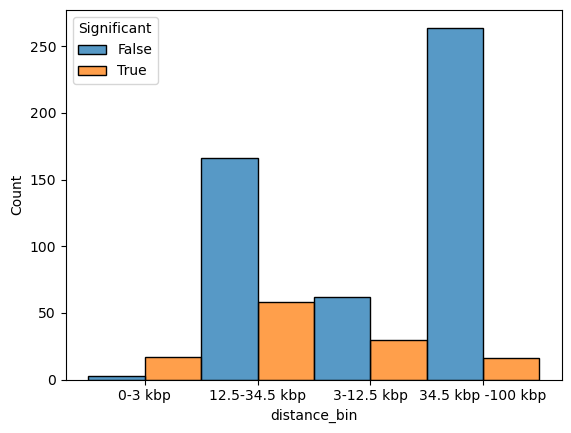

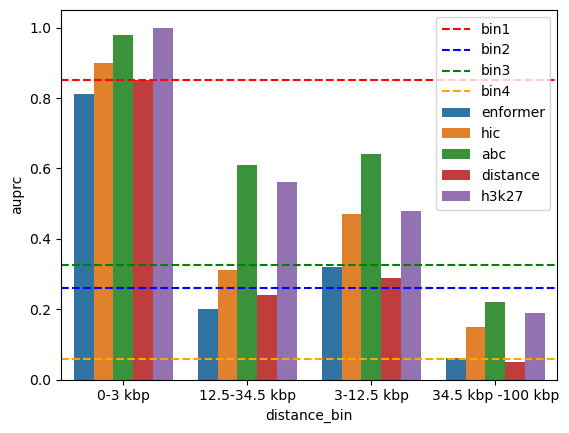

,0,1,2,3
pos,17.00,58.000000,30.000000,16.000000
neg,3.00,166.000000,62.000000,264.000000
ratios,0.85,0.258929,0.326087,0.057143


In [35]:
links = get_enhancer_gene_scores(eg_links_basenji, plot = False)
auprc_df_basenji = add_distance_bins(links, tested_pairs, plot=True)
df_basenji, ratio_df_basenji = compute_average_precision_per_bin(auprc_df_basenji, plot=True)
pd.DataFrame(ratio_df).T

In [36]:
auprc_df_basenji


,gene_name,enhancer,enformer_score,identifier,class,normalized_hic_contact,dhs_rpm,H3K27ac_rpm,ABC_score,Significant,...,gene_chr,gene_start,gene_end,enhancer_center,distance_enhancer_tss,tss_coord,gene_length,enh_length,1/distance,distance_bin
358,JUNB,chr19:12789831_12790351,760.194688,JUNB:chr19:12900645_12901165,intergenic,100.000000,11.260246,2.149584,0.049347,True,...,chr19,12725959,12857031,12790091,1404,12791495,131072,520,0.000712,0-3 kbp
167,CALR,chr19:12936451_12936951,609.164719,CALR:chr19:13047265_13047765,intergenic,90.877977,0.497241,1.125973,0.006789,False,...,chr19,12873063,13004135,12936701,1898,12938599,131072,500,0.000527,0-3 kbp
22,GATA1,chrX:48784617_48785277,20.235764,GATA1:chrX:48643025_48643685,intergenic,100.000000,1.534743,3.889724,0.027678,True,...,chrX,48721037,48852109,48784947,1626,48786573,131072,660,0.000615,0-3 kbp
144,C19orf43,chr19:12736851_12737708,291.491290,C19orf43:chr19:12847665_12848522,promoter,100.000000,47.310246,22.928901,0.322786,True,...,chr19,12669239,12800311,12737279,2504,12734775,131072,857,0.000399,0-3 kbp
29,HDAC6,chrX:48800621_48800667,154.960685,HDAC6:chrX:48659028_48659074,intergenic,44.348169,28.516506,10.133755,0.074928,True,...,chrX,48736479,48867551,48800644,1371,48802015,131072,46,0.000729,0-3 kbp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,COPZ1,chr12:54364236_54364736,27.940005,COPZ1:chr12:54758020_54758520,promoter,16.694466,0.440328,0.409445,0.000439,False,...,chr12,54259553,54390625,54364486,39397,54325089,131072,500,0.000025,34.5 kbp -100 kbp
210,COPZ1,chr12:54367481_54368001,45.474940,COPZ1:chr12:54761265_54761785,genic,14.021588,2.411983,1.125973,0.001430,False,...,chr12,54259553,54390625,54367741,42652,54325089,131072,520,0.000023,34.5 kbp -100 kbp
211,COPZ1,chr12:54368121_54368621,54.582539,COPZ1:chr12:54761905_54762405,genic,14.021588,1.887144,7.472365,0.003267,False,...,chr12,54259553,54390625,54368371,43282,54325089,131072,500,0.000023,34.5 kbp -100 kbp
409,LYL1,chr19:13162791_13163331,0.353911,LYL1:chr19:13273605_13274145,intergenic,15.280179,19.887075,7.881810,0.016099,False,...,chr19,13037624,13168696,13163061,59901,13103160,131072,540,0.000017,34.5 kbp -100 kbp


# Combined plot


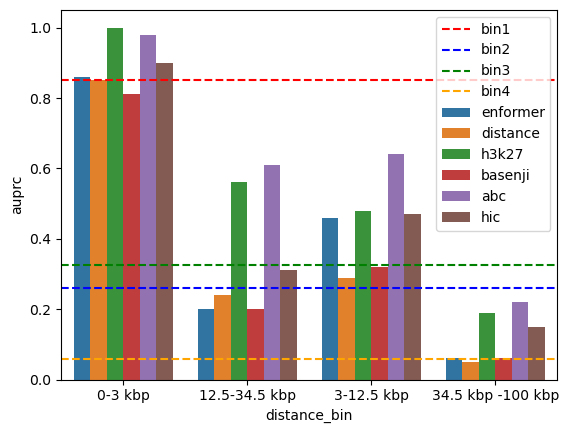

In [39]:
auprc_dict = {}
ratios = {"pos":[], "neg":[], "ratios": []}
for distance_bin in auprc_df.distance_bin.unique():
    sub = auprc_df.loc[auprc_df.distance_bin == distance_bin]
    sub_basenji = auprc_df_basenji.loc[auprc_df_basenji.distance_bin == distance_bin]
    y_true = sub.Significant.values
    enformer = np.round(average_precision_score(y_true, sub.enformer_score.values), 2)
    basenji = np.round(average_precision_score(sub_basenji.Significant.values, sub_basenji.enformer_score.values), 2)
    abc = np.round(average_precision_score(y_true, sub.ABC_score.values), 2)
    h3k27 = np.round(average_precision_score(y_true, sub.H3K27ac_rpm.values), 2)
    distance = np.round(average_precision_score(y_true, sub.distance_enhancer_tss.values), 2)
    hic = np.round(average_precision_score(y_true, sub.normalized_hic_contact.values), 2)
    auprc_dict[f"{distance_bin}"] = [enformer, basenji, abc, h3k27, distance, hic]
    
    ratios["ratios"].append(np.abs(sub.Significant.sum()) / sub.shape[0])
    ratios["pos"].append(int(np.abs(sub.Significant.sum())))
    ratios["neg"].append(int(np.abs(sub.shape[0] - int(np.abs(sub.Significant.sum())) )))

auprc_dict_df = pd.DataFrame(auprc_dict, index = ["enformer", "basenji", "abc", "h3k27", "distance", "hic"])
auprc_dict_df = auprc_dict_df.stack().reset_index().rename(columns={"level_0":"type", "level_1":"distance_bin", 0:"auprc"})
auprc_dict_df.sort_values(by="distance_bin", ascending=True, inplace=True)

#if plot:
sns.barplot(data=auprc_dict_df, x="distance_bin", y="auprc", hue="type")
for i, name, color in zip(ratios["ratios"], ["bin1", "bin2", "bin3", "bin4"], ["red", "blue", "green", "orange"]):
    plt.axhline(y=i, color=color, linestyle="--", label=name)
plt.legend()
plt.savefig(os.path.join(data_dir, "plots", "auprc_df_basenji_small_enf.pdf"), format="pdf")
plt.show()